# Factors of a Box Office Success

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

# Imports

In [135]:
import pandas as pd
import zipfile
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import Markdown
import difflib
import re

# Loading the Data

## im.db sqlite file
github only allows files up to 100MB so we must keep the im.db zipped and also work on it.

In [136]:
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as z:
    with z.open('im.db') as f:
        with open('/tmp/im.db', 'wb') as temp_db:
            temp_db.write(f.read())

conn = sqlite3.connect('/tmp/im.db')

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
display(tables)

df = pd.read_sql_query("SELECT * FROM movie_basics limit 10", conn)
display(df.info())



,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         10 non-null     object 
 1   primary_title    10 non-null     object 
 2   original_title   10 non-null     object 
 3   start_year       10 non-null     int64  
 4   runtime_minutes  7 non-null      float64
 5   genres           10 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 608.0+ bytes


None

## CSVs
Again we leave them zipped, pandas handles that for us.

In [137]:
bom_movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
display(bom_movie_gross.head())

tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
display(tmdb_movies.head())

tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
display(tn_movie_budgets.head())

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


## TSVs
They needed latin encoding or they didn't load right

In [138]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter='\t', encoding='latin0')
display(rt_movie_info.head())

rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin0')
display(rt_reviews.head())

LookupError: unknown encoding: latin0

## Recent IMDb Info from Flat Files

We obtained recent data from the [IMDb Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/) and trimmed it down to the last 10 years to fit within GitHub's file size limits.

This data was merged with reviews from the same source and saved as a DataFrame pickle file. The processing was done in a separate folder to avoid kernel crashes caused by the large file size. Chunking solved this issue, but to keep this notebook manageable, we store and load the pickle file here.

The file is `additional_data/imdb_flat_files/filtered_title_basics.tsv.gz`. From this, we parsed out the last 3 years of movie data to focus on what currently works at the box office and saved it as a pickle file `additional_data/last_three_years_movies_with_ratings.pkl`. However, it is used as a base for API calls to get more data, so it is not loaded here either.

### IMDb Flat File Last Ten Years

While we won't load the last 3 years pickle file we will load the last 10 years of IMDb data to check if the `im.db` and the flat files we have agree data-wise.

In [ ]:
def load_gzipped_tsv_in_chunks(file_path, chunk_size=10000):
    chunks = []
    for chunk in pd.read_csv(file_path, delimiter='\t', encoding='utf-8', chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks, ignore_index=True)

imdb_last_ten_years = load_gzipped_tsv_in_chunks('additional_data/imdb_flat_files/filtered_title_basics.tsv.gz')
#display(imdb_last_ten_years.head())

imdb_last_ten_years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195091 entries, 0 to 195090
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          195091 non-null  object
 1   titleType       195091 non-null  object
 2   primaryTitle    195091 non-null  object
 3   originalTitle   195091 non-null  object
 4   isAdult         195091 non-null  int64 
 5   startYear       195091 non-null  int64 
 6   endYear         195091 non-null  object
 7   runtimeMinutes  195091 non-null  object
 8   genres          195091 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.4+ MB


### Lets Select From im.db To Match The Format


In [ ]:
sql = """
SELECT * 
FROM movie_basics
WHERE start_year >= strftime('%Y', 'now', '-10 years')
"""
im_db = pd.read_sql_query(sql,conn)
im_db.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92899 entries, 0 to 92898
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         92899 non-null  object 
 1   primary_title    92899 non-null  object 
 2   original_title   92880 non-null  object 
 3   start_year       92899 non-null  int64  
 4   runtime_minutes  69999 non-null  float64
 5   genres           89198 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.3+ MB


## Comparing The Two
There is a huge difference in the size of the datasets for the last 10 years.

In [ ]:
#Normalize column names for imdb_last_ten_years for consistency
rename_cols = {
    'tconst': 'movie_id',
    'startYear': 'start_year', 
    'titleType': 'title_type',
    'originalTitle': 'original_title',
    'isAdult': 'is_adult',
    'endYear': 'end_year',
    'runtimeMinutes': 'runtime_minutes',
    'genres': 'genres'
}
imdb_last_ten_years.rename(columns=rename_cols, inplace=True)

# Ensure the movie_id column is the same type in both DataFrames
imdb_last_ten_years['movie_id'] = imdb_last_ten_years['movie_id'].astype(str)
im_db['movie_id'] = im_db['movie_id'].astype(str)

# Convert start_year and runtime_minutes to Int64 and handle missing values
imdb_last_ten_years['start_year'] = pd.to_numeric(imdb_last_ten_years['start_year'], errors='coerce').astype('Int64')
im_db['start_year'] = pd.to_numeric(im_db['start_year'], errors='coerce').astype('Int64')

imdb_last_ten_years['runtime_minutes'] = pd.to_numeric(imdb_last_ten_years['runtime_minutes'], errors='coerce').astype('Int64')
im_db['runtime_minutes'] = pd.to_numeric(im_db['runtime_minutes'], errors='coerce').astype('Int64')

# Merge both datasets on the movie_id using an inner join
merged_df = pd.merge(imdb_last_ten_years, im_db, on='movie_id', suffixes=('_flat', '_sql'), how='inner')

# Function to calculate scores
def calculate_scores(row, col):
    score_flat = 0
    score_sql = 0

    value_flat = row[col + '_flat']
    value_sql = row[col + '_sql']

    if pd.isna(value_flat) and pd.notna(value_sql):
        score_sql += 1
    elif pd.notna(value_flat) and pd.isna(value_sql):
        score_flat += 1
    elif pd.notna(value_flat) and pd.notna(value_sql):
        # Give them both a point if values are equal, this will make the score more intuitively correct if the two data sets mostly agree
        if value_flat == value_sql:
            score_flat += 1
            score_sql += 1
        # Penalize both for numeric discrepancies
        elif isinstance(value_flat, (int, float)) and isinstance(value_sql, (int, float)):
            score_flat -= 1
            score_sql -= 1
        elif isinstance(value_flat, str) and isinstance(value_sql, str):
            if len(value_flat) > len(value_sql):
                score_flat += 0.5
            elif len(value_flat) < len(value_sql):
                score_sql += 0.5

    return score_flat, score_sql

# Initialize scores
total_score_flat = 0
total_score_sql = 0

# Calculate scores for each row and column
for col in ['primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']:
    for _, row in merged_df.iterrows():
        rflat, rsql = calculate_scores(row, col)
        total_score_flat += rflat
        total_score_sql += rsql

# Print total scores
print(f"Total Score for IMDb Flat Files: {total_score_flat}")
print(f"Total Score for IMDb SQL Database: {total_score_sql}")

Total Score for IMDb Flat Files: 387940.0
Total Score for IMDb SQL Database: 377473.5


### Results of Comparison
It seems the data isn't too different, but as might be expected the newer data scores better.  This makes sense because newer data is often more filled out on sites that collect data.
So we would benefit with preferring the updated data set for both the score and reasoning.

We could merge the data sets to fill in missing, but missing info could be corrections in the new data set.  Likewise changes to genres could be intentional and more correct.

However, later on, we can leverage the fact the im.db goes further back and has things on actors etc if we need to.



## [Rapid API Movies Database](https://rapidapi.com/SAdrian/api/moviesdatabase)
This Movies Database has info we need, mainly box office data and production costs.  We also got as much else as we could though.

The `additional_data/last_three_years_movies_with_ratings.pkl` was used as the base and using the imdb id we fetched additional info on the following:
```python
infos = ["base_info", "genres", "revenue_budget", "releaseDate", "rating", "awards"]
```

The final merged results are loaded below in a pickle file, giving us comprehensive data on the last three years of movie data!

In [ ]:
movie_detailed = pd.read_pickle('additional_data/final_filtered_last_three_years_data.pkl')
movie_detailed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68006 entries, 0 to 68005
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movie_id               68006 non-null  object 
 1   title_type             68006 non-null  object 
 2   primary_title          68006 non-null  object 
 3   original_title         68006 non-null  object 
 4   is_adult               68006 non-null  object 
 5   start_year             68006 non-null  int64  
 6   end_year               68006 non-null  object 
 7   runtime_minutes        68006 non-null  object 
 8   genres                 68006 non-null  object 
 9   average_rating         32777 non-null  float64
 10  num_votes              32777 non-null  float64
 11  md_average_rating      32854 non-null  float64
 12  md_num_votes           67871 non-null  float64
 13  image_url              47166 non-null  object 
 14  image_caption          47166 non-null  object 
 15  md

Unfortunately after all that work (over 12 hours worth), the number of box office revenu columns we got was very small.  So we won't be able to use it much.

## Additional Data
We might use this later but we'll have to hand copy it.
https://the-numbers.com/movies/report/All/All/All/All/All/All/All/All/All/None/None/2020/2020/None/None/None/None/None/None?show-release-date=On&view-order-by=domestic-box-office&view-order-direction=desc&show-production-budget=On&show-domestic-box-office=On&show-inflation-adjusted-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&show-genre=On

# Data Exploration
Lets see what we have, identify what we can clean and then combine

## Summarize Our Data
We need a birds eye view of what we're looking at

In [ ]:
# Connect to the database
conn = sqlite3.connect('/tmp/im.db')

# Function to summarize a dataframe
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column': df.columns,
        'Non-Null Count': df.notnull().sum().values,
        'Dtype': df.dtypes.values,
        'Unique Values': df.nunique().values,
        'Sample Values': [get_top_values(df[col]) for col in df.columns]
    })
    return summary

# Function to get top 5 values by frequency
def get_top_values(series):
    top_values = Counter(series.dropna()).most_common(5)
    return [val[0] for val in top_values]
# Function to display summary with heading
def display_summary(title, df):
    p_md(title)
    display(summarize_dataframe(df))

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))


# Adjust display options to show more content in cells
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

# Display summaries
p_md("**Summaries**")

# Summarize im.db tables
im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

for table_name in im_db_tables['name']:
    display_summary(f"**table {table_name} in im.db:**", pd.read_sql_query(f"SELECT * FROM {table_name}", conn))

def df_summaries():
    # Summarize CSV dataframes
    display_summary("**bom_movie_gross dataframe:**", bom_movie_gross)
    display_summary("**tmdb_movies dataframe:**", tmdb_movies)
    display_summary("**tn_movie_budgets dataframe:**", tn_movie_budgets)

    # Summarize TSV dataframes
    display_summary("**rt_movie_info dataframe:**", rt_movie_info)
    display_summary("**rt_reviews dataframe:**", rt_reviews)

    # Summarize IMDb last ten years dataframe
    display_summary("**imdb_last_ten_years dataframe:**", imdb_last_ten_years)

df_summaries()

**Summaries**

**table movie_basics in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,146144,object,146144,"[tt0063540, tt0066787, tt0069049, tt0069204, tt0100275]"
1,primary_title,146144,object,136071,"[Home, Broken, The Return, Alone, Homecoming]"
2,original_title,146123,object,137773,"[Broken, Home, The Return, Alone, The Gift]"
3,start_year,146144,int64,19,"[2017, 2016, 2018, 2015, 2014]"
4,runtime_minutes,114405,float64,367,"[90.0, 80.0, 85.0, 100.0, 95.0]"
5,genres,140736,object,1085,"[Documentary, Drama, Comedy, Horror, Comedy,Drama]"


**table directors in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,291174,object,140417,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,291174,object,109253,"[nm6935209, nm2563700, nm1546474, nm3877467, nm3848412]"


**table known_for in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,1638260,object,576444,"[nm1202937, nm4291122, nm0958522, nm0509978, nm0218305]"
1,movie_id,1638260,object,514781,"[tt0806910, tt0441074, tt0203259, tt0486531, tt0452046]"


**table movie_akas in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,331703,object,122302,"[tt2488496, tt2310332, tt1201607, tt2278871, tt1790809]"
1,ordering,331703,int64,61,"[1, 2, 3, 4, 5]"
2,title,331703,object,252781,"[Robin Hood, Home, Alone, Broken, Love]"
3,region,278410,object,213,"[US, XWW, RU, DE, FR]"
4,language,41715,object,76,"[en, tr, bg, fr, he]"
5,types,168447,object,10,"[imdbDisplay, original, working, alternative, festival]"
6,attributes,14925,object,77,"[new title, alternative spelling, literal English title, complete title, original subtitled version]"
7,is_original_title,331678,float64,2,"[0.0, 1.0]"


**table movie_ratings in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,73856,object,73856,"[tt10356526, tt10384606, tt1042974, tt1043726, tt1060240]"
1,averagerating,73856,float64,91,"[7.0, 6.6, 7.2, 6.8, 6.5]"
2,numvotes,73856,int64,7349,"[6, 5, 7, 8, 9]"


**table persons in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,person_id,606648,object,606648,"[nm0061671, nm0061865, nm0062070, nm0062195, nm0062798]"
1,primary_name,606648,object,577203,"[James Brown, Michael Brown, David Brown, Michael Johnson, Mark Davis]"
2,birth_year,82736,float64,267,"[1978.0, 1980.0, 1979.0, 1982.0, 1981.0]"
3,death_year,6783,float64,214,"[2018.0, 2017.0, 2016.0, 2015.0, 2013.0]"
4,primary_profession,555308,object,8647,"[actor, actress, producer, composer, writer]"


**table principals in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,1028186,object,143454,"[tt0323808, tt0417610, tt0469152, tt0475290, tt0477302]"
1,ordering,1028186,int64,10,"[1, 2, 3, 4, 5]"
2,person_id,1028186,object,604546,"[nm1930572, nm0000636, nm0000616, nm0103977, nm4394575]"
3,category,1028186,object,12,"[actor, director, actress, producer, cinematographer]"
4,job,177684,object,2965,"[producer, screenplay, director of photography, writer, co-director]"
5,characters,393360,object,174762,"[[""Himself""], [""Herself""], [""Narrator""], [""Alex""], [""David""]]"


**table writers in im.db:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,255873,object,110261,"[tt4050462, tt3091166, tt2249786, tt4942694, tt3528906]"
1,person_id,255873,object,122576,"[nm6935209, nm1546474, nm0000636, nm2780568, nm4677186]"


**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,object,1204,"[1200000, 1100000, 1900000, 4200000, 2500000]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,object,3433,"[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,object,2418,"[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,object,509,"[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]"
4,domestic_gross,5782,object,5164,"[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]"
5,worldwide_gross,5782,object,5356,"[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]"


**rt_movie_info dataframe:**

Column  Non-Null Count    Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,40915,object,186,"[3/5, 4/5, 3/4, 2/5, 2/4]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,datetime64[ns],5963,"[2000-01-01 00:00:00, 2003-05-20 00:00:00, 2005-12-06 00:00:00, 2011-09-07 00:00:00, 2002-07-26 00:00:00]"


**imdb_last_ten_years dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,85478,object,85478,"[tt0069049, tt0100275, tt0111414, tt0112502, tt0137204]"
1,title_type,85478,object,1,[movie]
2,primary_title,85478,object,81075,"[The Return, Run, Alone, Brothers, Home]"
3,original_title,85478,object,82070,"[The Return, Run, Alone, Home, Freedom]"
4,is_adult,85478,int64,2,"[0, 1]"
5,start_year,85478,Int64,16,"[2016, 2017, 2015, 2018, 2014]"
6,end_year,85478,object,1,[\N]
7,runtime_minutes,71091,Int64,299,"[90, 80, 85, 100, 95]"
8,genres,85478,object,963,"[Documentary, Drama, Comedy, \N, Horror]"


Awesome! This summary will let us see all sorts of useful info and we can refer back to it during the entire project!

Time to roll up our sleeves and use this summary to try to identify places that need cleaning.

## Analyze Columns
Lets analyze, algorithmically!  This will let us generalize the problem.  We will still manually go over it but this should let us find things that would otherwise be missed, or take untold time to find.

In [ ]:
# Function to determine if a column contains date time values
def is_datetime(series):
    try:
        pd.to_datetime(series, errors='raise')
        return True
    except:
        return False

# Function to determine if a column contains money values
def is_money(series):
    # List of common currency symbols
    currency_symbols = r'[$€£¥₹]'
    # Regex pattern for money values
    money_pattern = rf'{currency_symbols}?\d+(,\d{{3}})*(\.\d{{2}})?'
    return series.dropna().astype(str).str.match(money_pattern).all()

# Function to determine if a column contains numeric values
def is_numeric(series):
    try:
        pd.to_numeric(series, errors='raise')
        return True
    except:
        return False

def analyze_dataframe(df, df_name):
    missing_data_cols = []
    high_missing_data_cols = []
    duplicate_value_cols = []
    incorrect_dtype_cols = []
    potential_duplicates_dict = {}

    # Identify columns with missing data
    for col in df.columns:
        sumnull = int(df[col].isnull().sum())
        sumall = int(df[col].count())
        if sumnull > 0:
            missing_data_cols.append(col)
        if sumnull / sumall > .4:
            high_missing_data_cols.append(col)
    
        if df[col].dtype == 'object':
            # Find wrong data types
            #This wasn't reliable to find data type issues
            '''
            if is_numeric(df[col]):
                incorrect_dtype_cols.append((col, 'numeric'))
            elif is_datetime(df[col]):
                incorrect_dtype_cols.append((col, 'datetime'))
            elif is_money(df[col]):
                incorrect_dtype_cols.append((col, 'money'))
            else:
            ''' 
            #takes over 2 hours and still didn't complete so we can't find mislabled data via expensive computation
            '''
            # Find potential data that has malformed labels using value counts under 10
            value_counts = df[col].dropna().value_counts()
            unique_values = value_counts.index[value_counts < 10]
            potential_duplicates = []
            
            set_dict = {value: set(value.lower().split()) for value in unique_values}
            
            for value, set1 in set_dict.items():
                for other_value, set2 in set_dict.items():
                    if value != other_value and len(set1 & set2) / max(len(set1), len(set2)) > 0.86:
                        potential_duplicates.append((value, other_value))
            
            if potential_duplicates:
                duplicate_value_cols.append(col)
                potential_duplicates_dict[col] = potential_duplicates
            '''
    # Print the findings for the current dataframe
    p_md(f"### Analysis for {df_name}:")
    if len(missing_data_cols) > 0:
        p_md(f"**missing data:** {missing_data_cols}")
    if len(high_missing_data_cols) > 0:
        p_md(f"**high missing data:** {high_missing_data_cols}")
    if len(duplicate_value_cols) > 0:
        p_md(f"**potential duplicate value issues:** {duplicate_value_cols}")
    if len(incorrect_dtype_cols) > 0:
        p_md(f"**incorrect data types:** {incorrect_dtype_cols}")

    for col, duplicates in potential_duplicates_dict.items():
        p_md(f"**Column:** {col} Potential Duplicates")
        for dup in duplicates:
            p_md(f"{dup[0]} <-> {dup[1]}")

# Utility function to print markdown
def p_md(text):
    display(Markdown(text))

# Analyzing each dataframe

# IMDb database tables
im_db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table_name in im_db_tables['name']:
    table_df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    analyze_dataframe(table_df, f"table {table_name} in im.db")

# CSV dataframes
analyze_dataframe(bom_movie_gross, "bom_movie_gross dataframe")
analyze_dataframe(tmdb_movies, "tmdb_movies dataframe")
analyze_dataframe(tn_movie_budgets, "tn_movie_budgets dataframe")

# TSV dataframes
analyze_dataframe(rt_movie_info, "rt_movie_info dataframe")
analyze_dataframe(rt_reviews, "rt_reviews dataframe")

# IMDb last ten years dataframe
analyze_dataframe(imdb_last_ten_years, "imdb_last_ten_years dataframe")

### Analysis for table movie_basics in im.db:

**missing data:** ['original_title', 'runtime_minutes', 'genres']

### Analysis for table directors in im.db:

### Analysis for table known_for in im.db:

### Analysis for table movie_akas in im.db:

**missing data:** ['region', 'language', 'types', 'attributes', 'is_original_title']

**high missing data:** ['language', 'types', 'attributes']

### Analysis for table movie_ratings in im.db:

### Analysis for table persons in im.db:

**missing data:** ['birth_year', 'death_year', 'primary_profession']

**high missing data:** ['birth_year', 'death_year']

### Analysis for table principals in im.db:

**missing data:** ['job', 'characters']

**high missing data:** ['job', 'characters']

### Analysis for table writers in im.db:

### Analysis for bom_movie_gross dataframe:

**missing data:** ['studio', 'domestic_gross', 'foreign_gross']

**high missing data:** ['foreign_gross']

### Analysis for tmdb_movies dataframe:

### Analysis for tn_movie_budgets dataframe:

### Analysis for rt_movie_info dataframe:

**missing data:** ['synopsis', 'rating', 'genre', 'director', 'writer', 'currency', 'box_office', 'runtime', 'studio']

**high missing data:** ['writer', 'currency', 'box_office', 'studio']

### Analysis for rt_reviews dataframe:

**missing data:** ['review', 'rating', 'critic', 'publisher']

### Analysis for imdb_last_ten_years dataframe:

**missing data:** ['runtime_minutes']

# Data Cleaning
In this section we clean data

## Correct Data Types We Detect

### Columns identified to have the wrong data types
<pre>
tmdb_movies dataframe:
release_date	26517	object	3433	[2010-01-01, 2011-01-01, 2012-01-01, 2014-01-01, 2013-01-01]


tn_movie_budgets dataframe:
1	release_date	5782	object	2418	[Dec 31, 2014, Dec 31, 2015, Dec 31, 2010, Dec 31, 2008, Dec 31, 2012]
3	production_budget	5782	object	509	[$20,000,000, $10,000,000, $30,000,000, $15,000,000, $25,000,000]
4	domestic_gross	5782	object	5164	[$0, $8,000,000, $7,000,000, $2,000,000, $10,000,000]
5	worldwide_gross	5782	object	5356	[$0, $8,000,000, $7,000,000, $2,000,000, $15,000,000]

rt_movie_info dataframe:
6	theater_date	1560	int64	1026	[-9223372036854775808, 536457600000000000, 757382400000000000, -126230400000000000, 94694400000000000]
7	dvd_date	1560	int64	718	[-9223372036854775808, 1086048000000000000, 1005004800000000000, 1031011200000000000, 872640000000000000]
9	box_office	340	object	336	[600,000, 200,000, 32,000,000, 20,900,803, 41,032,915]
10	runtime	1530	object	142	[90 minutes, 95 minutes, 100 minutes, 93 minutes, 96 minutes]

rt_reviews dataframe:
2	rating	40915	object	186	[3/5, 4/5, 3/4, 2/5, 2/4
7	date	54432	object	5963	[January 1, 2000, May 20, 2003, December 6, 2005, September 7, 2011, July 26, 2002]
</pre>

In [139]:
# Function to clean and convert money columns
def clean_money_column(series):
    return series.replace('[\$,]', '', regex=True).astype(float)

# Function to clean and convert runtime columns
def clean_runtime_column(series):
    return series.str.replace(' minutes', '').astype(float)

# Fixing columns in tmdb_movies dataframe
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], errors='coerce')

# Fixing columns in tn_movie_budgets dataframe
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'], errors='coerce')
tn_movie_budgets['production_budget'] = clean_money_column(tn_movie_budgets['production_budget'])
tn_movie_budgets['domestic_gross'] = clean_money_column(tn_movie_budgets['domestic_gross'])
tn_movie_budgets['worldwide_gross'] = clean_money_column(tn_movie_budgets['worldwide_gross'])

# Fixing columns in rt_movie_info dataframe
rt_movie_info['theater_date'] = pd.to_datetime(rt_movie_info['theater_date'], errors='coerce')
rt_movie_info['dvd_date'] = pd.to_datetime(rt_movie_info['dvd_date'], errors='coerce')
rt_movie_info['box_office'] = clean_money_column(rt_movie_info['box_office'])
rt_movie_info['runtime'] = clean_runtime_column(rt_movie_info['runtime'])

# Fixing columns in rt_reviews dataframe
# Assuming the rating column is like '3/5' and we want to convert it to a float representing the percentage (e.g., 0.6)
def convert_rating(series):
    def to_percentage(value):
        try:
            num, denom = value.split('/')
            return float(num) / float(denom)
        except:
            return None

    return series.apply(lambda x: to_percentage(x) if isinstance(x, str) else x)

rt_reviews['rating'] = convert_rating(rt_reviews['rating'])
rt_reviews['date'] = pd.to_datetime(rt_reviews['date'], errors='coerce')

In [140]:
#Lets check we were successful
df_summaries()

**bom_movie_gross dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,title,3387,object,3386,"[Bluebeard, Toy Story 3, Alice in Wonderland (2010), Harry Potter and the Deathly Hallows Part 1, Inception]"
1,studio,3382,object,257,"[IFC, Uni., WB, Fox, Magn.]"
2,domestic_gross,3359,float64,1797,"[1100000.0, 1000000.0, 1300000.0, 1200000.0, 1400000.0]"
3,foreign_gross,2037,object,1204,"[1200000, 1100000, 1900000, 4200000, 2500000]"
4,year,3387,int64,9,"[2015, 2016, 2012, 2011, 2014]"


**tmdb_movies dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,Unnamed: 0,26517,int64,26517,"[0, 1, 2, 3, 4]"
1,genre_ids,26517,object,2477,"[[99], [], [18], [35], [27]]"
2,id,26517,int64,25497,"[70758, 11976, 109581, 91311, 152044]"
3,original_language,26517,object,76,"[en, fr, es, ru, ja]"
4,original_title,26517,object,24835,"[Eden, Home, Lucky, Legend, Truth or Dare]"
5,popularity,26517,float64,7425,"[0.6, 1.4, 0.84, 0.624, 0.625]"
6,release_date,26517,datetime64[ns],3433,"[2010-01-01 00:00:00, 2011-01-01 00:00:00, 2012-01-01 00:00:00, 2014-01-01 00:00:00, 2013-01-01 00:00:00]"
7,title,26517,object,24688,"[Home, Eden, The Gift, Lucky, Legend]"
8,vote_average,26517,float64,91,"[6.0, 7.0, 5.0, 10.0, 8.0]"
9,vote_count,26517,int64,1693,"[1, 2, 3, 4, 5]"


**tn_movie_budgets dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,5782,int64,100,"[1, 2, 3, 4, 5]"
1,release_date,5782,datetime64[ns],2418,"[2014-12-31 00:00:00, 2015-12-31 00:00:00, 2010-12-31 00:00:00, 2008-12-31 00:00:00, 2012-12-31 00:00:00]"
2,movie,5782,object,5698,"[King Kong, Home, Halloween, The Avengers, Robin Hood]"
3,production_budget,5782,float64,509,"[20000000.0, 10000000.0, 30000000.0, 15000000.0, 25000000.0]"
4,domestic_gross,5782,float64,5164,"[0.0, 8000000.0, 7000000.0, 2000000.0, 10000000.0]"
5,worldwide_gross,5782,float64,5356,"[0.0, 8000000.0, 7000000.0, 2000000.0, 15000000.0]"


**rt_movie_info dataframe:**

Column  Non-Null Count           Dtype  Unique Values                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

**rt_reviews dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,id,54432,int64,1135,"[782, 1067, 1525, 1083, 1777]"
1,review,48869,object,48682,"[Parental Content Review, full review at Movies for the Masses, full review in Greek, Click to read review, click to read the full review]"
2,rating,33695,float64,72,"[0.6, 0.8, 0.5, 0.75, 0.4]"
3,fresh,54432,object,2,"[fresh, rotten]"
4,critic,51710,object,3496,"[Emanuel Levy, Roger Ebert, Dennis Schwartz, Nell Minow, Frank Swietek]"
5,top_critic,54432,int64,2,"[0, 1]"
6,publisher,54123,object,1281,"[eFilmCritic.com, EmanuelLevy.Com, New York Times, Washington Post, Entertainment Weekly]"
7,date,54432,datetime64[ns],5963,"[2000-01-01 00:00:00, 2003-05-20 00:00:00, 2005-12-06 00:00:00, 2011-09-07 00:00:00, 2002-07-26 00:00:00]"


**imdb_last_ten_years dataframe:**

,Column,Non-Null Count,Dtype,Unique Values,Sample Values
0,movie_id,85478,object,85478,"[tt0069049, tt0100275, tt0111414, tt0112502, tt0137204]"
1,title_type,85478,object,1,[movie]
2,primary_title,85478,object,81075,"[The Return, Run, Alone, Brothers, Home]"
3,original_title,85478,object,82070,"[The Return, Run, Alone, Home, Freedom]"
4,is_adult,85478,int64,2,"[0, 1]"
5,start_year,85478,Int64,16,"[2016, 2017, 2015, 2018, 2014]"
6,end_year,85478,object,1,[\N]
7,runtime_minutes,71091,Int64,299,"[90, 80, 85, 100, 95]"
8,genres,85478,object,963,"[Documentary, Drama, Comedy, \N, Horror]"


Great!  Our columns look to be of the proper types now!

## Missing Data
We don't want to change the distribution of data.  We also want to keep as much data as possible.
Sometimes we may find we can fill missing data based on that info being elsewhere in the other data sets.

For now lets just make sure that we don't use missing data in any of our graphs.

Analysis for table movie_basics in im.db:
missing data: ['original_title', 'runtime_minutes', 'genres']

Analysis for table directors in im.db:
Analysis for table known_for in im.db:
Analysis for table movie_akas in im.db:
missing data: ['region', 'language', 'types', 'attributes', 'is_original_title']

high missing data: ['language', 'types', 'attributes']

Analysis for table movie_ratings in im.db:
Analysis for table persons in im.db:
missing data: ['birth_year', 'death_year', 'primary_profession']

high missing data: ['birth_year', 'death_year']

Analysis for table principals in im.db:
missing data: ['job', 'characters']

high missing data: ['job', 'characters']

Analysis for table writers in im.db:
Analysis for bom_movie_gross dataframe:
missing data: ['studio', 'domestic_gross', 'foreign_gross']

high missing data: ['foreign_gross']

incorrect data types: [('foreign_gross', 'money')]

Analysis for tmdb_movies dataframe:
incorrect data types: [('release_date', 'datetime')]

Analysis for tn_movie_budgets dataframe:
incorrect data types: [('release_date', 'datetime'), ('production_budget', 'money'), ('domestic_gross', 'money'), ('worldwide_gross', 'money')]

Analysis for rt_movie_info dataframe:
missing data: ['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']

high missing data: ['writer', 'currency', 'box_office', 'studio']

incorrect data types: [('theater_date', 'datetime'), ('dvd_date', 'datetime'), ('box_office', 'money'), ('runtime', 'money')]

Analysis for rt_reviews dataframe:
missing data: ['review', 'rating', 'critic', 'publisher']

incorrect data types: [('date', 'datetime')]

Analysis for imdb_last_ten_years dataframe:
missing data: ['runtime_minutes']

Analysis for merged dataframe:
missing data: ['runtime_minutes_flat', 'runtime_minutes_sql']

# Data Combining
Our project has a lot of different sources of data so lets focus on seeing what we can combine

In [ ]:
movie_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)
# Load lookup tables for genres and persons
genres_lookup = pd.read_sql_query("SELECT * FROM genres", conn)
persons_lookup = pd.read_sql_query("SELECT * FROM persons", conn)

# Function to expand genre_ids
def expand_genre_ids(row, genres_lookup):
    if pd.isna(row):
        return []
    genre_ids = eval(row) if isinstance(row, str) else row
    return [genres_lookup[genres_lookup['genre_id'] == genre_id]['genre_name'].values[0] for genre_id in genre_ids]

# Apply the function to expand genre_ids in tmdb_movies
tmdb_movies['genre_names'] = tmdb_movies['genre_ids'].apply(expand_genre_ids, genres_lookup=genres_lookup)

# Merge one-to-one relationships
super_df = movie_basics.merge(bom_movie_gross, left_on='movie_id', right_on='title', how='left')
super_df = super_df.merge(tn_movie_budgets, left_on='movie_id', right_on='movie', how='left')
super_df = super_df.merge(rt_movie_info, left_on='movie_id', right_on='id', how='left')
super_df = super_df.merge(imdb_last_ten_years, on='movie_id', how='left')

# Merge expanded genres into super_df
super_df = super_df.merge(tmdb_movies[['id', 'genre_names']], left_on='movie_id', right_on='id', how='left')

# Create sub-dataframes for one-to-many relationships
directors = pd.read_sql_query("SELECT * FROM directors", conn)
known_for = pd.read_sql_query("SELECT * FROM known_for", conn)
movie_akas = pd.read_sql_query("SELECT * FROM movie_akas", conn)
movie_ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)
principals = pd.read_sql_query("SELECT * FROM principals", conn)
writers = pd.read_sql_query("SELECT * FROM writers", conn)
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter='\t', encoding='latin1')

# Expand person details in principals
principals = principals.merge(persons_lookup[['person_id', 'primary_name']], on='person_id', how='left')

# Now we have super_df for one-to-one relationships and sub-dataframes for one-to-many relationships with expanded data
# We can proceed with further analysis or processing as needed

# Display the first few rows of the super_df to check the expansion
display(super_df.head())

# Display the first few rows of the expanded principals dataframe
display(principals.head())

## Monetary amounts to floats

In [10]:
# Converting the monetary amounts to float values for easy manipulation

tn_movie_budgets['domestic_gross'] = tn_movie_budgets['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(float)

tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000.0,0.0,0.000000e+00
5778,79,"Apr 2, 1999",Following,6000.0,48482.0,2.404950e+05
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400.0,0.0,0.000000e+00


## Date/Time Conversions

In [11]:
# Converting the release dates to date/time format

tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])

tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


# Exploratory Data Analysis

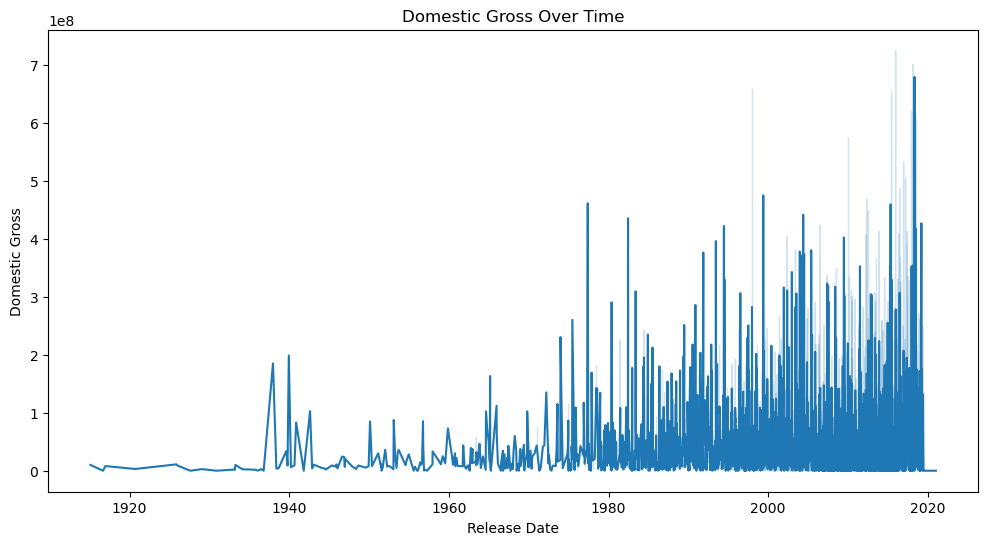

In [12]:
# Just getting a visual of domestic gross over the years

plt.figure(figsize=(12, 6))
sns.lineplot(x='release_date', y='domestic_gross', data=tn_movie_budgets)
plt.title('Domestic Gross Over Time')
plt.xlabel('Release Date')
plt.ylabel('Domestic Gross')
plt.show()


## Filtering Data

In [16]:
# Cutting down the dates to the past 10 years to narrow the search for more relevant data

current_date = pd.to_datetime('today')
cutoff_date = current_date - pd.DateOffset(years=4)

recent_tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['release_date'] >= cutoff_date]

recent_tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,95,2020-12-31,Moonfall,150000000.0,0.0,0.0
1205,6,2020-12-31,Hannibal the Conqueror,50000000.0,0.0,0.0


In [15]:
# Subtracted the cost of production from the domestic gross to try to find profit

tn_movie_budgets['movie_profit'] = tn_movie_budgets['domestic_gross'] - tn_movie_budgets['production_budget']
tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_profit
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,335507625.0
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-169536125.0
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-307237650.0
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,128405868.0
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,303181382.0
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00,-7000.0
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05,42482.0
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,-3662.0
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00,-1400.0


# Close the im.db connection
It's always good practice to ensure you closed the connection

In [2]:

# Close the connection
conn.close()

NameError: name 'conn' is not defined